In [1]:
sc.install_pypi_package("matplotlib")
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import sum
import matplotlib.pyplot as plt
import numpy as np

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
6,application_1589764007238_0007,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

In [2]:
covid_mundial_confirmados.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'covid_mundial_confirmados' is not defined
Traceback (most recent call last):
NameError: name 'covid_mundial_confirmados' is not defined



In [3]:
covid_colombia.filter(covid_colombia['estado']=="Fallecido").filter(covid_colombia['Edad'] > 25).groupBy('Departamento o Distrito ').count().orderBy('count',ascending=False).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'covid_colombia' is not defined
Traceback (most recent call last):
NameError: name 'covid_colombia' is not defined



In [4]:
datasets_s3 = 's3://proyecto3-datasets/datasets'
confirmed_global = spark.read.csv(datasets_s3 + '/Mundial/time_series_covid19_confirmed_global.csv', inferSchema=True, header=True)
deaths_global = spark.read.csv(datasets_s3 + '/Mundial/time_series_covid19_deaths_global.csv', inferSchema=True, header=True)
recovered_global = spark.read.csv(datasets_s3 + '/Mundial/time_series_covid19_recovered_global.csv', inferSchema=True, header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
tcg = confirmed_global.groupBy('Country/Region').agg(sum('5/8/20').alias('total')).collect()
tdg = deaths_global.groupBy('Country/Region').agg(sum('5/8/20').alias('total')).collect()
trg = recovered_global.groupBy('Country/Region').agg(sum('5/8/20').alias('total')).collect()
active_cases = []
for i in range(len(tcg)):
    if tcg[i][0] == tdg[i][0] and trg[i][0] == tdg[i][0]:
        total = tcg[i][-1] - tdg[i][-1] - trg[i][-1]
        active_cases.append([tcg[i][0], total])
    else:
        trg[i], trg[i+1] = trg[i+1], trg[i]
        total = tcg[i][-1] - tdg[i][-1] - trg[i][-1]
        active_cases.append([tcg[i][0], total])
        
schema = StructType([
    StructField('Country/Region', StringType(), True),
    StructField('Active Cases', IntegerType(), True),
])


active_cases = spark.createDataFrame(active_cases, schema)
active_cases_order_desc = active_cases.orderBy('Active Cases', ascending=False)
active_cases_order_desc.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+------------+
|Country/Region|Active Cases|
+--------------+------------+
|            US|     1007756|
|United Kingdom|      180316|
|        Russia|      159528|
|        France|       94077|
|         Italy|       87961|
|        Brazil|       77580|
|         Spain|       65410|
|        Turkey|       45484|
|          Peru|       41121|
|         India|       39823|
|   Netherlands|       36768|
|        Canada|       32738|
|       Belgium|       30289|
|  Saudi Arabia|       26083|
|      Portugal|       23732|
|       Ecuador|       23681|
|       Germany|       21378|
|     Singapore|       19647|
|      Pakistan|       18306|
|         Qatar|       17819|
+--------------+------------+
only showing top 20 rows

In [6]:
paises = [country['Country/Region'] for country in active_cases_order_desc.select('Country/Region').collect()]
recuperados = [country['Active Cases'] for country in active_cases_order_desc.select('Active Cases').collect()]

plt.switch_backend("agg")
fig, axs = plt.subplots(figsize=(18, 5))
axs.bar(paises[:15], recuperados[:15])
axs.invert_xaxis()
fig.suptitle('Casos activos por país')
plt.xlabel('País')
plt.ylabel('Casos')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0, 0.5, 'Casos')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

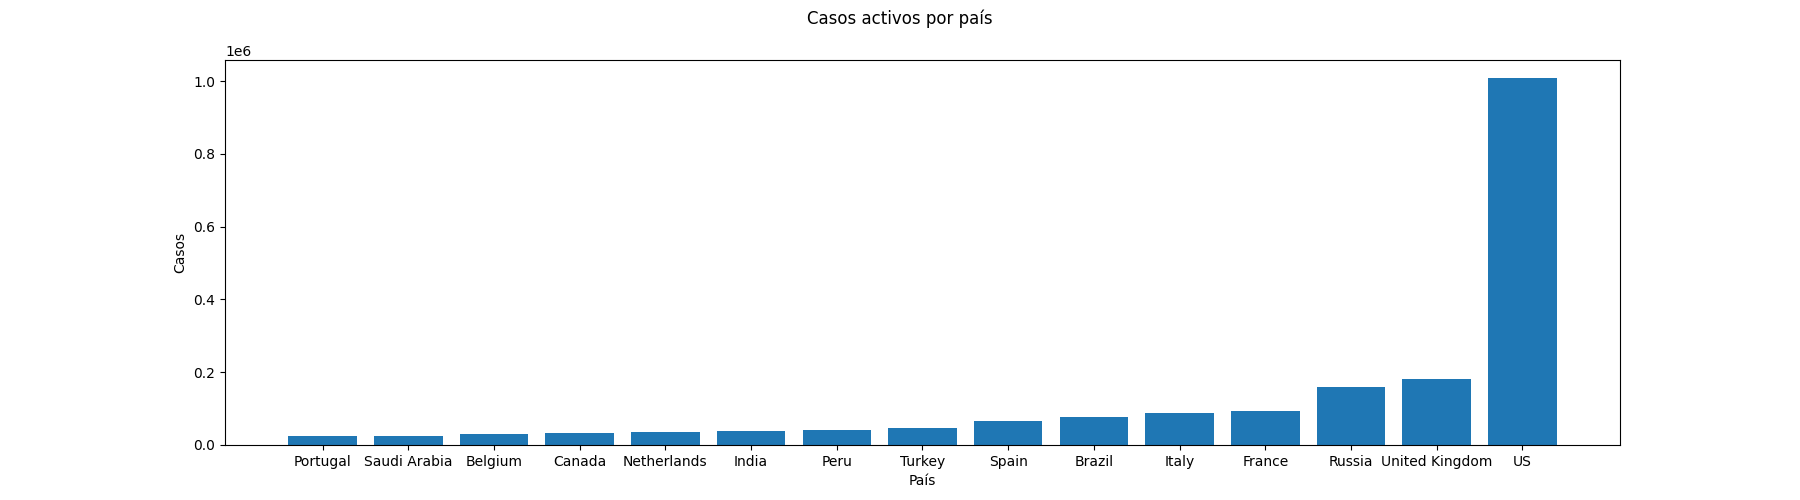

In [7]:
%matplot plt

In [8]:
colombia_data = spark.read.csv('s3://covidcs/datasets/colombia/Covid-19 Colombia.csv', inferSchema=True, header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
deaths_colombia = colombia_data.filter(colombia_data['estado'] == 'Fallecido').select('estado', 'sexo','edad')
deaths_colombia.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

428

In [10]:
edadMuerte = deaths_colombia.groupBy('edad').count().orderBy('edad', ascending=True)

edad = [country['edad'] for country in edadMuerte.select('edad').collect()]
muertes = [country['count'] for country in edadMuerte.select('count').collect()]

fig, axs = plt.subplots(figsize=(20, 5))
axs.bar(edad[:15], muertes[:15])
fig.suptitle('Muertes por edad en Colombia entre 0 y 30 años')
plt.xlabel('Edad')
plt.ylabel('Muertes')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0, 0.5, 'Muertes')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

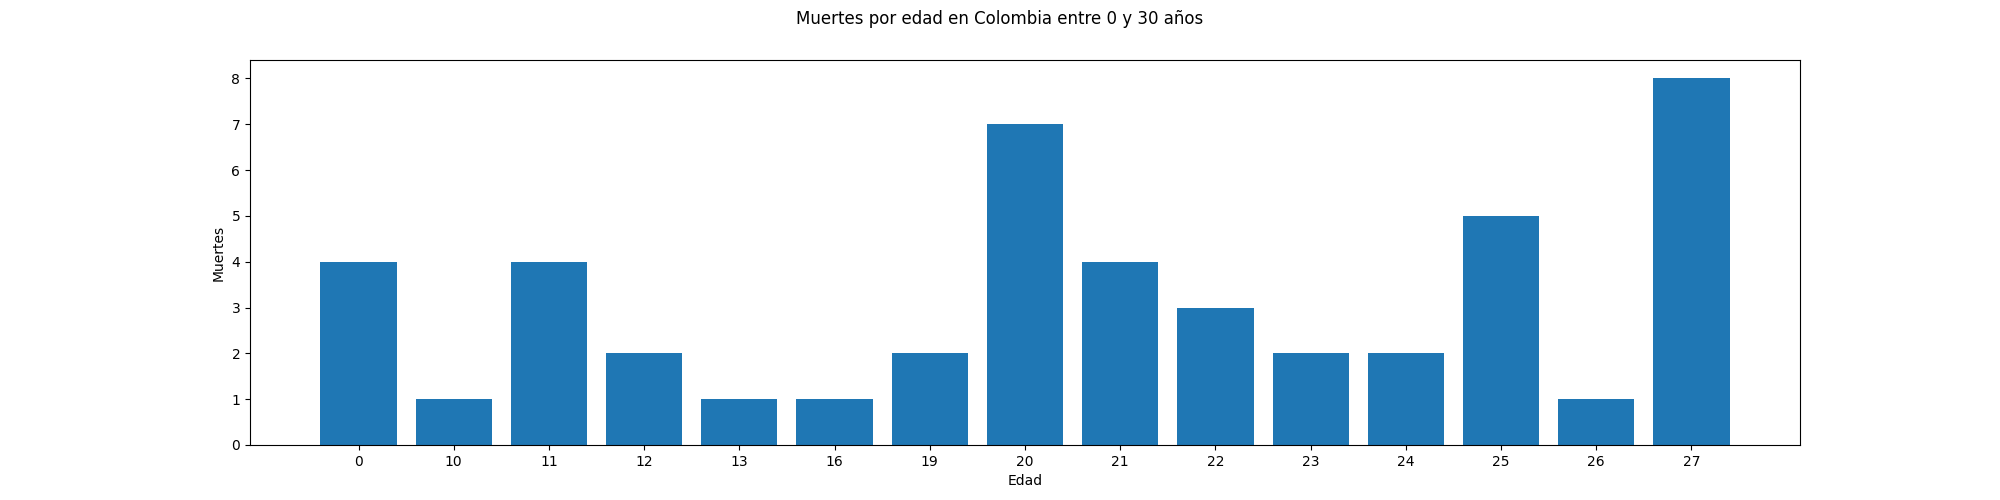

In [11]:
%matplot plt

In [12]:
globalConfirmado = confirmed_global.collect()

plotGlobal = []
plotColombia = []

for i in range(4, len(globalConfirmado[0])):
    cases_col = 0
    cases_glo = 0
    for j in range(0, len(globalConfirmado)):
        if globalConfirmado[j][1] == 'Colombia':
            cases_col = cases_col + globalConfirmado[j][i]
        else:
            cases_glo = cases_glo + globalConfirmado[j][i]
    plotGlobal.append(cases_glo)
    plotColombia.append(cases_col)
       
        
x1 = list(range(1, len(globalConfirmado[0]) - 3))

y1 = plotGlobal
y2 = plotColombia

plt.clf()
plt.subplot(2, 1, 1)
plt.plot(x1, y1, '.-')
plt.title('Casos confirmados')
plt.ylabel('Global')

plt.subplot(2, 1, 2)
plt.plot(x1, y2, '.-')
plt.xlabel('Día')
plt.ylabel('Colombia')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0, 0.5, 'Colombia')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

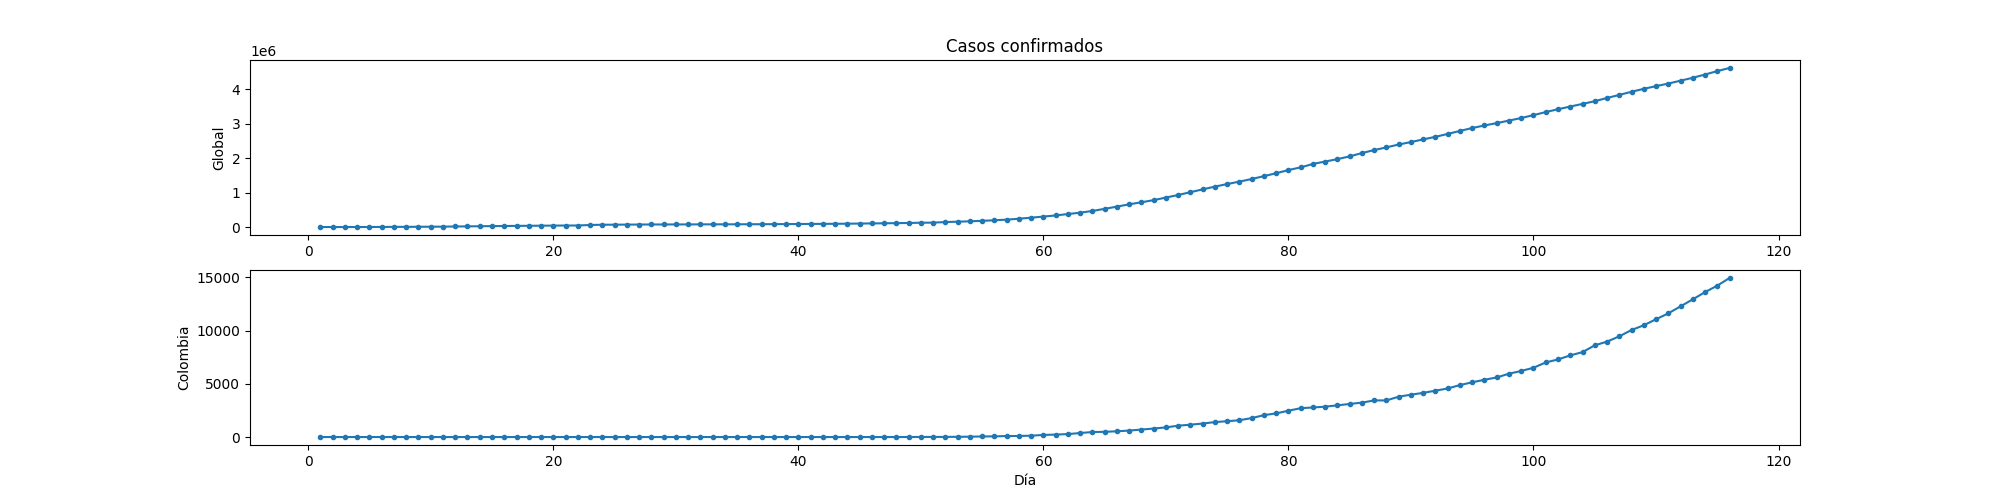

In [13]:
%matplot plt